In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
!pip install pyxlsb

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving Subnational Level 1 life expectancy.xlsb to Subnational Level 1 life expectancy.xlsb


In [5]:
df1 = pd.read_excel("Subnational Level 1 life expectancy.xlsb", engine="pyxlsb")
#df2 = pd.read_excel(r"\Users\rmada\OneDrive\Desktop\sublvl2.xlsb", engine="pyxlsb")
#df3 = pd.read_excel(r"\Users\rmada\OneDrive\Desktop\sublvl.xlsb", engine="pyxlsb")



In [9]:

shift=df1.iloc[:, 5:37]
newDF=shift.T
#df1=df1.rename(columns={"Region":"Year"})
newDF.columns=df1["Region"]

ts = newDF.drop("Total", axis=1)




In [120]:
ts.columns

Index(['Hauts Plateaux Centre (Djelfa, Laghouat, MSila)',
       'Hauts Plateaux Est (Setif, Batna, Khenchela, Bordj Bou Arreridj, Oum El Bouaghi, Tebessa)',
       'Hauts Plateaux Ouest (Tiaret, Saida, Tissemsilt, Naama, El Bayadh)',
       'Nord Centre (Alger, Blida, Boumerdes, Tipaza, Bouira, Medea, Tizi-Ouzou, Bejaia, Chlef, Ain Defla)',
       'Nord Est (Annaba, Constantine, Skikda, Jijel, Mila, Souk Ahras, El Tarf, Guelma)',
       'Nord Ouest (Oran, Tlemcen, Mostaganem, Ain Temouchent, Relizane, Sidi Bel Abbes, Mascara)',
       'Sud (Bechar, Tindouf, Adrar, Ghardaia, Biskra, El Oued, Ouargla, Tamanrasset,Illizi)',
       ' Bengo', ' Benguela', ' Bie',
       ...
       'Bulawayo', 'Harare', 'Manicaland', 'Mashonaland Central',
       'Mashonaland East', 'Mashonaland West', 'Masvingo',
       'Matebeleland North', 'Matebeleland South', 'Midlands'],
      dtype='object', name='Region', length=1079)

Text(0.5, 1.0, 'Average Life Expectancy at Birth Per Year')

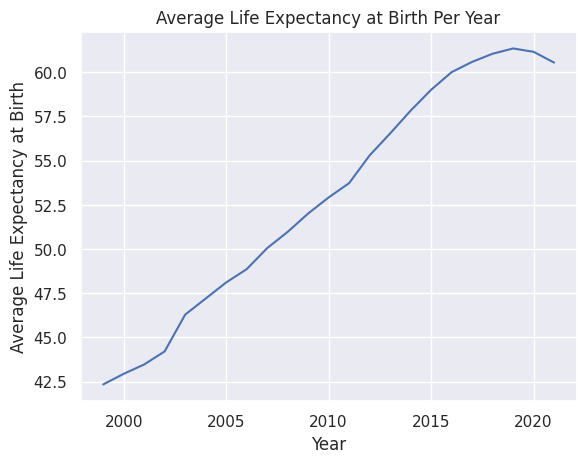

In [121]:
hpd = ts[ts.columns[15]]
rD=sns.lineplot(hpd)
plt.ylabel("Average Life Expectancy at Birth")
plt.xlabel("Year")
plt.title("Average Life Expectancy at Birth Per Year")


In [ ]:
hpd = hpd.dropna()


In [83]:
rolling_mean = hpd.rolling(7).mean()
rolling_std = hpd.rolling(7).std()


In [84]:
mainCol=hpd.columns[0]

Text(0, 0.5, 'Rolling Mean of Life Expectancy')

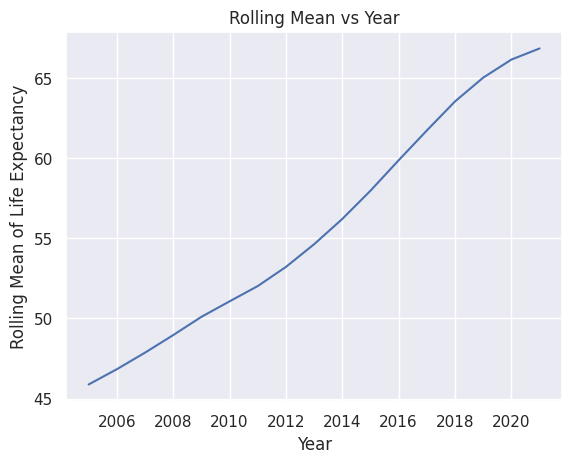

In [85]:
plt.plot(rolling_mean)
plt.title("Rolling Mean vs Year")
plt.xlabel("Year")
plt.ylabel("Rolling Mean of Life Expectancy")

Text(0, 0.5, 'Rolling Standard Deviation')

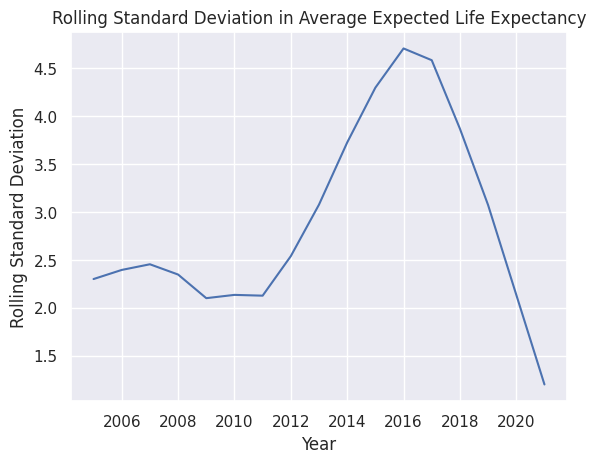

In [86]:
plt.plot(rolling_std)
plt.title("Rolling Standard Deviation in Average Expected Life Expectancy")
plt.xlabel("Year")
plt.ylabel("Rolling Standard Deviation")

In [54]:
from statsmodels.tsa.stattools import adfuller

In [88]:
ad = adfuller(hpd, autolag="AIC")

In [89]:
output_hpd = pd.DataFrame({"Values":[ad[0],ad[1],ad[2],ad[3], ad[4]['1%'], ad[4]['5%'], ad[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_hpd)

      Values                       Metric
0  -1.550383              Test Statistics
1   0.508457                      p-value
2   1.000000             No. of lags used
3  21.000000  Number of observations used
4  -3.788386          critical value (1%)
5  -3.013098          critical value (5%)
6  -2.646397         critical value (10%)


In [90]:
autocorrelation_lag1 = hpd[mainCol].autocorr(lag=1)
print("One Year Lag: ", autocorrelation_lag1)

One Year Lag:  0.9951348003861559


In [91]:
autocorrelation_lag3 = hpd[mainCol].autocorr(lag=3)
print("Three Year Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = hpd[mainCol].autocorr(lag=6)
print("Six Year Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = hpd[mainCol].autocorr(lag=9)
print("Nine Year Lag: ", autocorrelation_lag9)

Three Year Lag:  0.9688931807459421
Six Year Lag:  0.9267388226365849
Nine Year Lag:  0.9450225293496172


In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

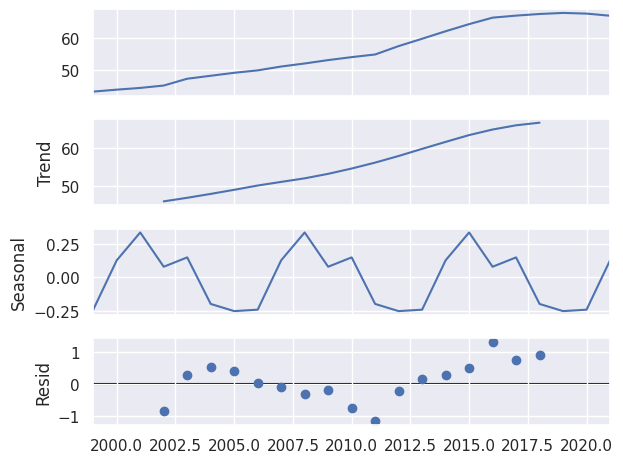

In [92]:
decompose = seasonal_decompose(hpd,model='additive', period=7)
decompose.plot()
plt.show()

<ipython-input-104-b2fb3dddab48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train[mainCol]
<ipython-input-104-b2fb3dddab48>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test[mainCol]


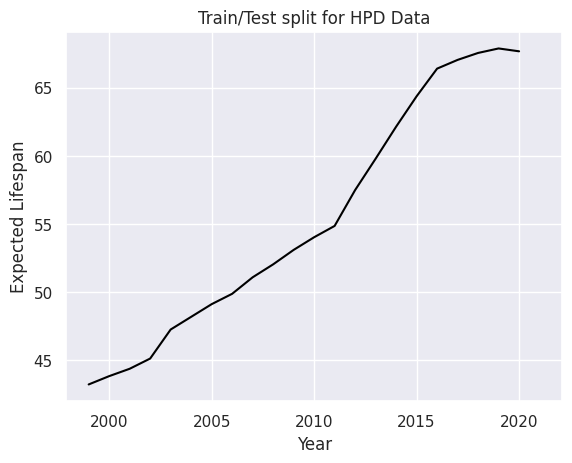

In [104]:
hpd['Year'] = hpd.index
train = hpd[hpd['Year'] < 2021]
train['train'] = train[mainCol]
del train['Year']
del train[mainCol]
test = hpd[hpd['Year'] >= 2021]
del test['Year']
test['test'] = test[mainCol]
del test[mainCol]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for HPD Data")
plt.ylabel("Expected Lifespan")
plt.xlabel('Year')
sns.set()
plt.show()

In [118]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
years=8
model=ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=4).fit(smoothing_level=0.9)
y_pred = model.forecast(steps=years)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)


In [116]:
editedHP = hpd.drop(['Year'], axis=1)

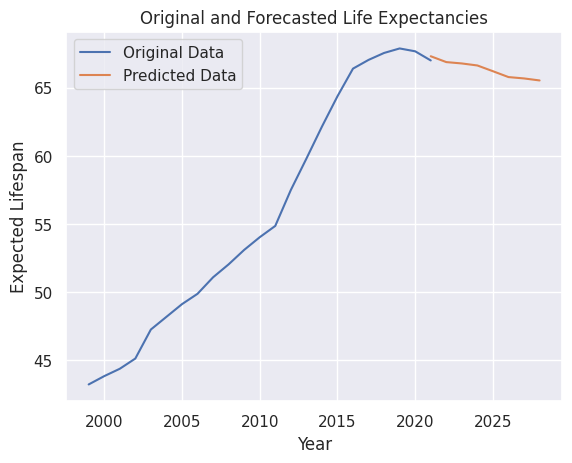

In [123]:
indexVal = np.array(range(test.index[0], test.index[0]+years))
y_pred.values
forecast = pd.DataFrame(y_pred.values, index=indexVal, columns=[mainCol])


original = pd.DataFrame(editedHP.values, index=np.array(range(min(train.index), max(test.index)+1)), columns=[mainCol])

plt.plot(original, label="Original Data")
plt.plot(forecast, label="Predicted Data")
plt.title("Original and Forecasted Life Expectancies")
plt.ylabel("Expected Lifespan")
plt.xlabel('Year')
plt.legend(loc="best")